# Cover Image

In [57]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from myUtils import convert_ode_parameters,  calc_critical_treatment_threshold, calc_critical_treatment_interval
from odeModels import LotkaVolterraModel
from plotUtils import PlotDrug, PlotSimulation


In [58]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['N0'] = odeParamDic['n0']

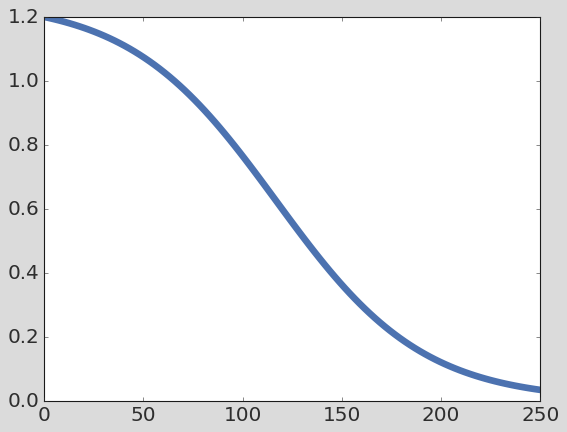

In [60]:
# Variation of threshold with critical interval
odeParamDic = convert_ode_parameters(n0=0.8, rFrac=0.001, cost=0, turnover=0.0)
odeParamDic['N0'] = odeParamDic['n0']

tau_values = np.linspace(0, 250, 100)
n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]

plt.plot(tau_values, n_stars, linewidth=6, label='Critical threshold')

In [61]:
def calc_ttp(params, n_crit, interval):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

In [ ]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator

dx, dy = 2, 0.01
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 251 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

with open('data/ttp_array.pkl', 'wb') as file:
    pickle.dump(ttp_values, file)

In [62]:
with open('data/ttp_array.pkl', 'rb') as file:
    # Use pickle.load() to deserialize and load the array
    ttp_values = pickle.load(file)
ttp_values = ttp_values[:-1, :-1]

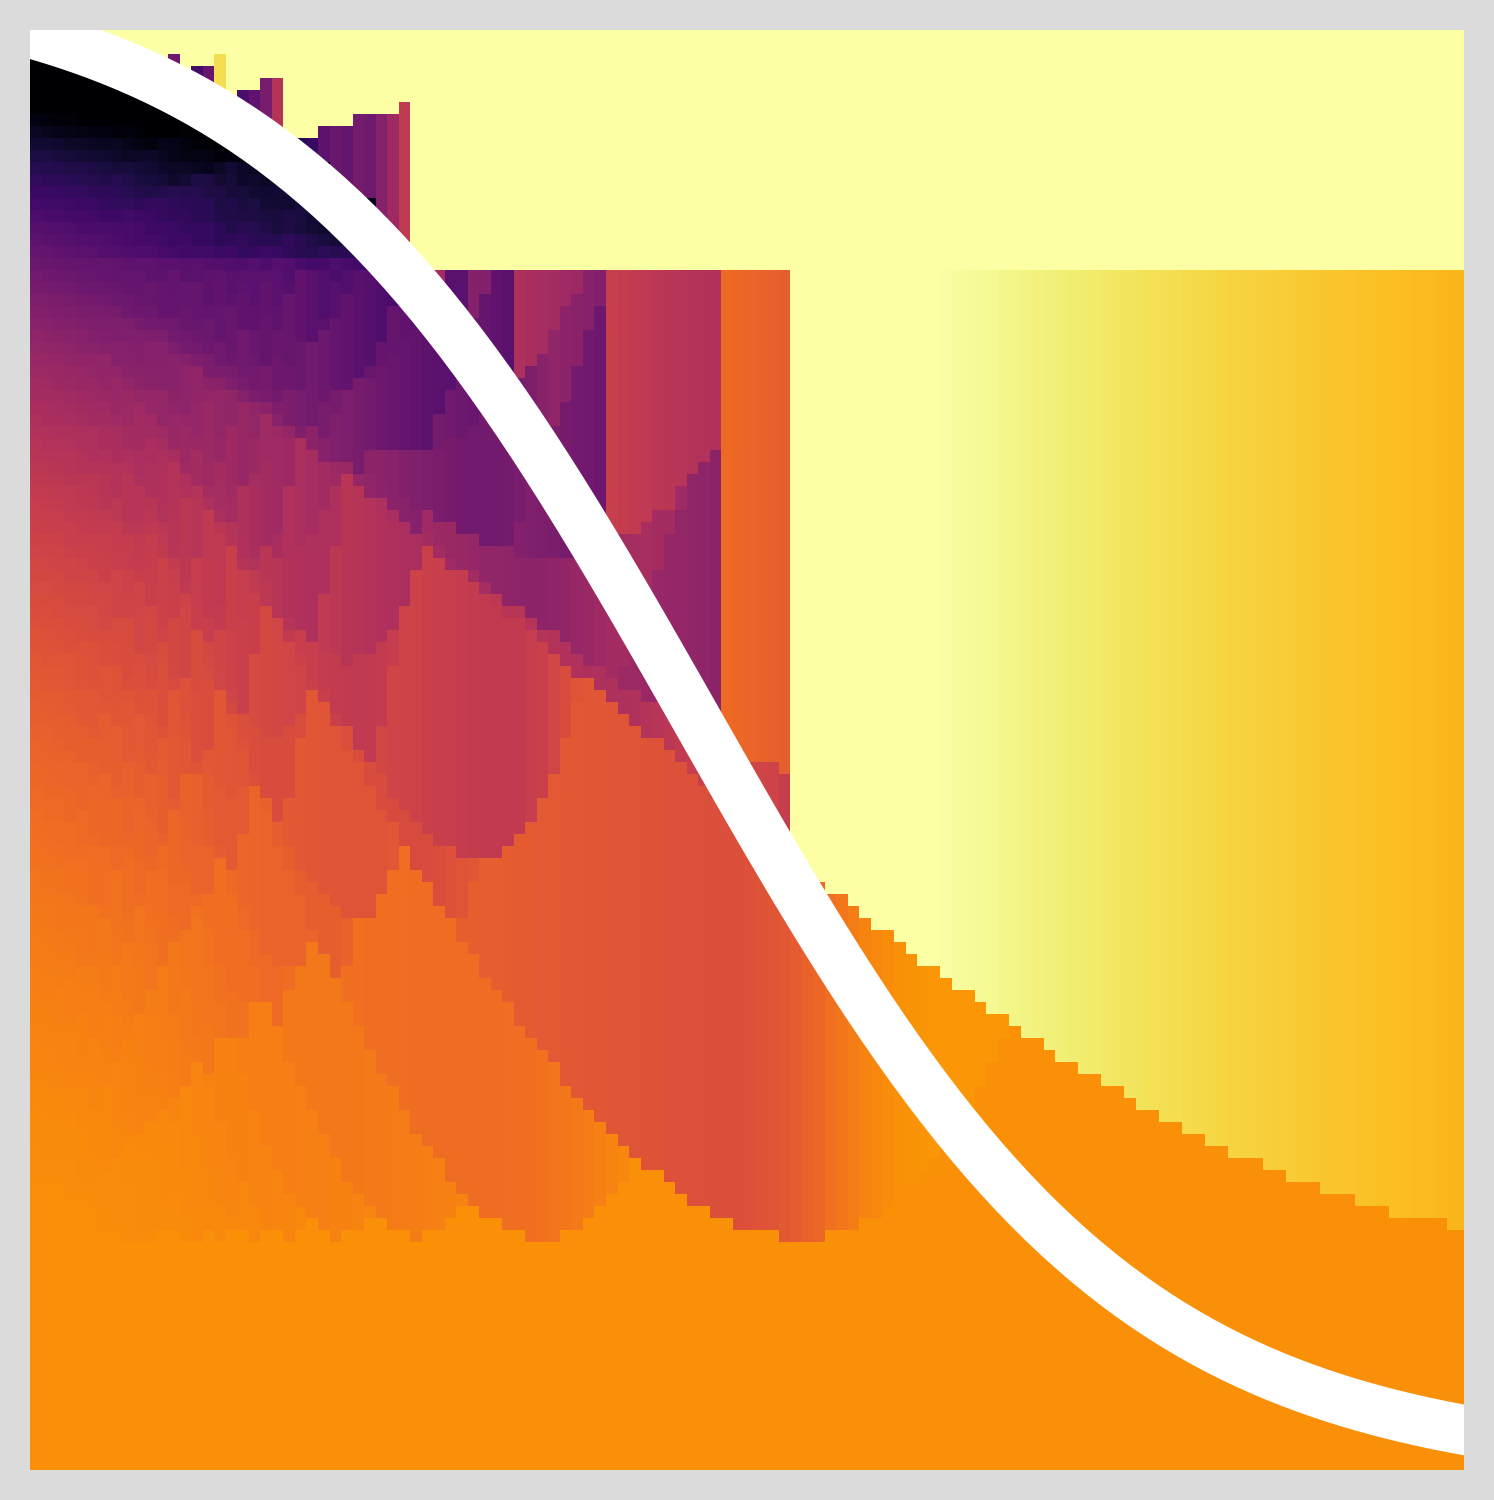

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(dpi=300)

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('inferno_r'), norm=LogNorm(vmin=300, vmax=2500))

n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 12, zorder=5, color='w', label = 'Optimal\nThreshold'); 

ax.set_xlim(1, 250); 
plt.axis('off') 
ax.set_aspect(250 / np.max(crit_n_grid))
plt.savefig("../figures/lotka_volterra_model_threshold_fullr_log.png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()